In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels import regression

from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
mapdf = pd.read_csv('SHR76_20.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### After we've loaded the data, let's check to make sure it looks okay.

In [3]:
mapdf.head()

,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,StateName,...,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,MSA
0,197609001AL00400,"Autauga, AL",AL00400,Alabama,Autauga County,Sheriff,FBI,No,1976,NaN,...,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Other,NaN,0,0,30180.0,"Montgomery, AL"
1,197701001AL00400,"Autauga, AL",AL00400,Alabama,Autauga County,Sheriff,FBI,Yes,1977,NaN,...,Black,Unknown or not reported,Other or type unknown,Acquaintance,Brawl due to influence of alcohol,NaN,0,0,30180.0,"Montgomery, AL"
2,197703001AL00400,"Autauga, AL",AL00400,Alabama,Autauga County,Sheriff,FBI,Yes,1977,NaN,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Acquaintance,Other arguments,NaN,0,1,30180.0,"Montgomery, AL"
3,197703001AL00401,"Autauga, AL",AL00401,Alabama,Prattville,Municipal police,FBI,Yes,1977,NaN,...,Black,Unknown or not reported,Shotgun,Husband,Other arguments,NaN,0,0,30180.0,"Montgomery, AL"
4,197708001AL00400,"Autauga, AL",AL00400,Alabama,Autauga County,Sheriff,FBI,Yes,1977,NaN,...,Black,Unknown or not reported,Knife or cutting instrument,Acquaintance,Circumstances undetermined,NaN,0,0,30180.0,"Montgomery, AL"


In [4]:
mapdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827219 entries, 0 to 827218
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            827219 non-null  object 
 1   CNTYFIPS      827219 non-null  object 
 2   Ori           827219 non-null  object 
 3   State         827219 non-null  object 
 4   Agency        827219 non-null  object 
 5   Agentype      827219 non-null  object 
 6   Source        827219 non-null  object 
 7   Solved        827219 non-null  object 
 8   Year          827219 non-null  int64  
 9   StateName     22468 non-null   object 
 10  Month         827219 non-null  object 
 11  Incident      827219 non-null  int64  
 12  ActionType    827219 non-null  object 
 13  Homicide      827219 non-null  object 
 14  Situation     827219 non-null  object 
 15  VicAge        827219 non-null  int64  
 16  VicSex        827219 non-null  object 
 17  VicRace       827219 non-null  object 
 18  VicE

#### We need to add a proper datetime column. Note that Year is a number. Change that to string and then concat new string to Month.

In [5]:
mapdf['Year_str'] = mapdf['Year'].astype('str')

In [6]:
mapdf['monthyear'] = mapdf['Month'] + '-' + mapdf['Year_str']

In [7]:
mapdf['datetime'] = pd.to_datetime(mapdf['monthyear'])

#### Tada! Now we have a new datetime column that is in the type: datetime

#### We have a lot of NaNs in StateName and Subcircum. I wonder why. Let's look at .info() to see if we can check any others.

In [8]:
mapdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827219 entries, 0 to 827218
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ID            827219 non-null  object        
 1   CNTYFIPS      827219 non-null  object        
 2   Ori           827219 non-null  object        
 3   State         827219 non-null  object        
 4   Agency        827219 non-null  object        
 5   Agentype      827219 non-null  object        
 6   Source        827219 non-null  object        
 7   Solved        827219 non-null  object        
 8   Year          827219 non-null  int64         
 9   StateName     22468 non-null   object        
 10  Month         827219 non-null  object        
 11  Incident      827219 non-null  int64         
 12  ActionType    827219 non-null  object        
 13  Homicide      827219 non-null  object        
 14  Situation     827219 non-null  object        
 15  VicAge        827

#### Looks like it's basically those two columns. But first, let's normalize all column names (so it's easier to call when we need them)

In [9]:
mapdf.columns = mapdf.columns.str.lower()

#### Check to see what the values are for the columns with NaNs

In [10]:
mapdf['subcircum'].value_counts()

Felon killed in commission of a crime    11346
Felon attacked police officer             9562
Felon attacked a civilian                 5633
Not enough information to determine       2581
Felon resisted arrest                     1314
Felon attacked fellow police officer      1098
Felon attempted flight from a crime        917
Name: subcircum, dtype: int64

In [11]:
mapdf['statename'].value_counts()

FLA       2769
CALIFO    2379
TEXAS     2140
ILLINO    1072
MICHIG     848
NORTH      846
NEW YO     820
OHIO       787
TENNES     747
LOUISI     734
SOUTH      640
MISSOU     619
GEORGI     606
VIRGIN     584
INDIAN     546
ARIZON     523
MARYLA     513
WISCON     423
KENTUC     366
OKLAHO     363
COLORA     349
ARKANS     340
WASHIN     337
NEW JE     336
PENNSY     272
MISSIS     237
MINNES     230
DISTRI     216
NEVADA     206
OREGON     173
MASSAC     167
CONNEC     161
NEW ME     154
IOWA       124
WEST V     120
UTAH       112
KANSAS      95
DELAWA      79
MONTAN      69
NEBRAS      67
ALASKA      56
IDAHO       49
HAWAII      42
RHODE       32
MAINE       29
ALABAM      24
NEW HA      24
WYOMIN      20
VERMON      18
FEDERA       4
FLORID       1
Name: statename, dtype: int64

#### Looks like the statename column can be dropped.

In [12]:
mapdf.drop(columns = 'statename', inplace=True)

#### Check the dataset again...

In [13]:
mapdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827219 entries, 0 to 827218
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            827219 non-null  object        
 1   cntyfips      827219 non-null  object        
 2   ori           827219 non-null  object        
 3   state         827219 non-null  object        
 4   agency        827219 non-null  object        
 5   agentype      827219 non-null  object        
 6   source        827219 non-null  object        
 7   solved        827219 non-null  object        
 8   year          827219 non-null  int64         
 9   month         827219 non-null  object        
 10  incident      827219 non-null  int64         
 11  actiontype    827219 non-null  object        
 12  homicide      827219 non-null  object        
 13  situation     827219 non-null  object        
 14  vicage        827219 non-null  int64         
 15  vicsex        827

#### Any other NAs in the dataset?

In [14]:
mapdf.isna().sum()

id                   0
cntyfips             0
ori                  0
state                0
agency               0
agentype             0
source               0
solved               0
year                 0
month                0
incident             0
actiontype           0
homicide             0
situation            0
vicage               0
vicsex               0
vicrace              0
vicethnic            0
offage               0
offsex               0
offrace              0
offethnic            0
weapon               0
relationship         0
circumstance         0
subcircum       794768
viccount             0
offcount             0
filedate          2510
msa                  0
year_str             0
monthyear            0
datetime             0
dtype: int64

#### Dropping subcircum

In [15]:
mapdf.drop(columns = 'subcircum', inplace=True)

#### There are a few more NAs in filedate.

In [16]:
mapdf['filedate']

0          30180.0
1          30180.0
2          30180.0
3          30180.0
4          30180.0
            ...   
827214    121482.0
827215     61987.0
827216     22795.0
827217     90704.0
827218     81711.0
Name: filedate, Length: 827219, dtype: float64

#### Not really sure why these are numbered like that. Maybe we can drop it.

In [17]:
mapdf.drop(columns = 'filedate', inplace=True)

#### Cool. Now let's check out the stats of this dataset.

In [18]:
mapdf.describe()

,year,incident,vicage,offage,viccount,offcount
count,827219.000000,827219.000000,827219.000000,827219.000000,827219.000000,827219.000000
mean,1996.991040,28.947475,47.540888,352.717006,0.128523,0.185658
std,13.008957,110.180594,118.824307,456.035658,0.564474,0.596206
min,1976.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1986.000000,1.000000,22.000000,24.000000,0.000000,0.000000
50%,1996.000000,2.000000,30.000000,38.000000,0.000000,0.000000
75%,2008.000000,10.000000,42.000000,999.000000,0.000000,0.000000
max,2020.000000,999.000000,999.000000,999.000000,21.000000,40.000000


#### Wow, victim ages go up to 999? This must be a fill-in number. Just how many 999s are there? 

In [19]:
mapdf['vicage'].value_counts().sort_values(ascending = False)

22    29371
25    29310
21    28976
20    28837
23    28794
      ...  
99      148
95      115
96       56
97       55
98       37
Name: vicage, Length: 101, dtype: int64

#### That's not quite helpful. What about this?

In [20]:
mapdf['vicage'].value_counts()[999]

12476

#### Okay, so 999 occurs 12,476 times. That's not good. How can we solve this?

In [21]:
mapdf['vicage'].value_counts()[0]

10416

#### And the vicage as 0 happens 10,416 times. I suppose it can be true if they were less than a year old, but I can also believe that the majority are incorrect. 

In [22]:
mapdf['vicage'].value_counts()[99]

148

In [23]:
mapdf.columns

Index(['id', 'cntyfips', 'ori', 'state', 'agency', 'agentype', 'source',
       'solved', 'year', 'month', 'incident', 'actiontype', 'homicide',
       'situation', 'vicage', 'vicsex', 'vicrace', 'vicethnic', 'offage',
       'offsex', 'offrace', 'offethnic', 'weapon', 'relationship',
       'circumstance', 'viccount', 'offcount', 'msa', 'year_str', 'monthyear',
       'datetime'],
      dtype='object')

#### Thought I could cross the age with some other column to see if the zeroes were incorrect ages.

In [24]:
mapdf[mapdf['vicage']==0][['vicage','relationship']].value_counts()

vicage  relationship               
0       Son                            3745
        Daughter                       3098
        Relationship not determined    1392
        Other - known to victim         830
        Acquaintance                    516
        Other family                    331
        Stranger                        112
        Stepson                          72
        Friend                           71
        Stepdaughter                     56
        Girlfriend                       35
        Wife                             27
        Neighbor                         26
        Brother                          25
        Mother                           19
        Father                           18
        Sister                           16
        Common-law wife                   6
        Stepfather                        5
        Husband                           3
        Boyfriend                         3
        Homosexual relationship         

In [25]:
mapdf[mapdf['vicage']==999][['vicage','relationship']].value_counts()

vicage  relationship               
999     Relationship not determined    7846
        Acquaintance                   1339
        Stranger                       1176
        Son                             375
        Other - known to victim         329
        Daughter                        328
        Friend                          192
        Wife                            162
        Girlfriend                      131
        Other family                    128
        Husband                          73
        Neighbor                         60
        Boyfriend                        54
        Mother                           39
        Brother                          37
        In-law                           36
        Father                           35
        Common-law wife                  30
        Ex-wife                          24
        Common-law husband               24
        Homosexual relationship          11
        Stepson                         

#### Checking to see what the age distribution looks like! 

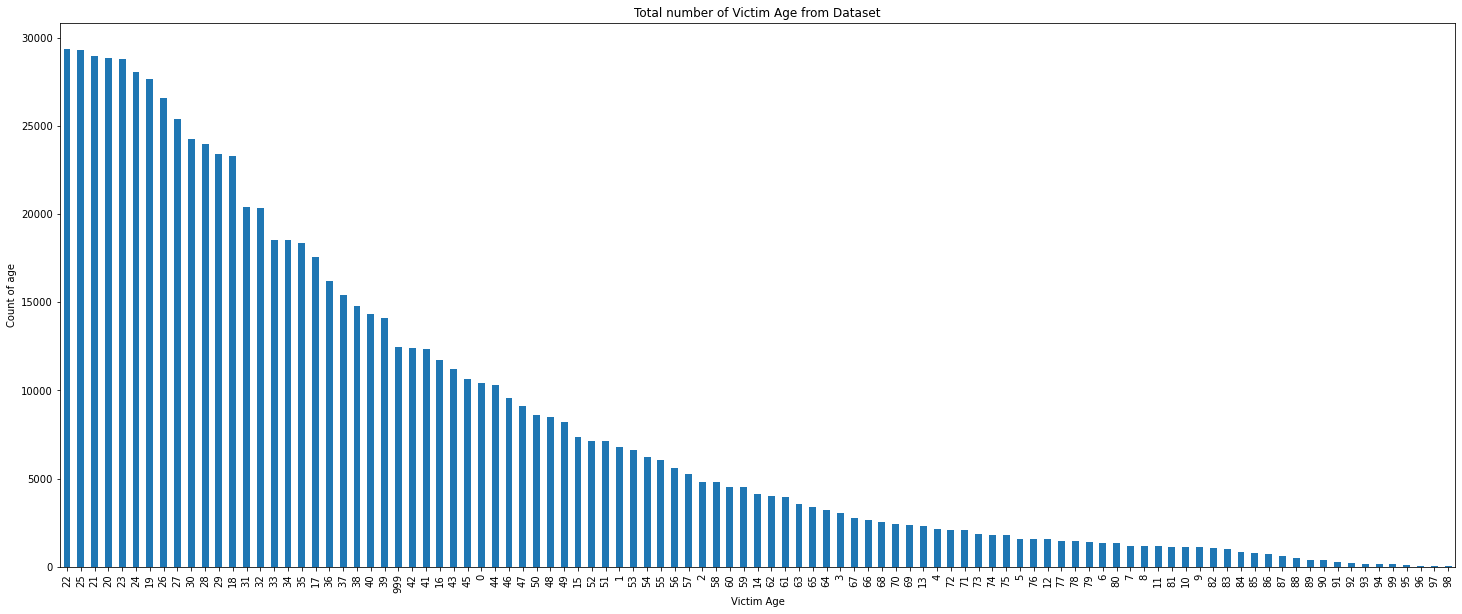

In [148]:
mapdf['vicage'].value_counts().plot(kind = 'bar',
                                  figsize = (25,10),
                                  xlabel = 'Victim Age',
                                  ylabel = 'Count of age',
                                  title = 'Total number of Victim Age from Dataset');

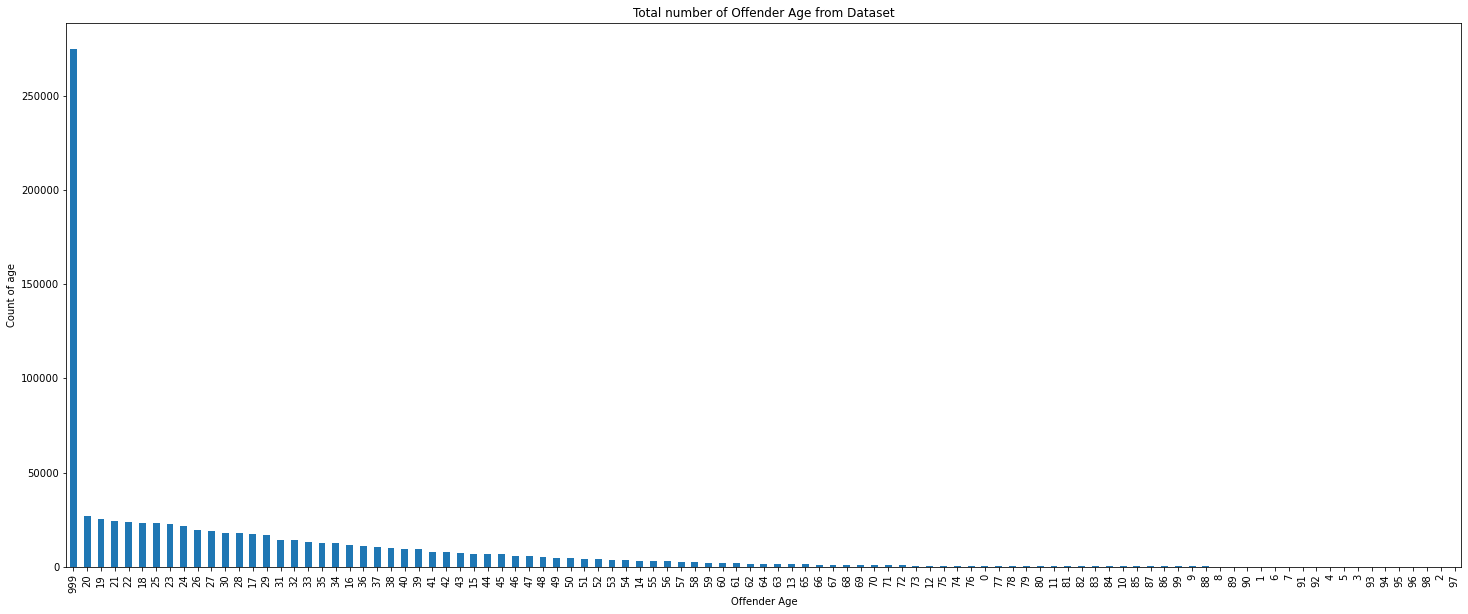

In [149]:
mapdf['offage'].value_counts().plot(kind = 'bar',
                                  figsize = (25,10),
                                  xlabel = 'Offender Age',
                                  ylabel = 'Count of age',
                                  title = 'Total number of Offender Age from Dataset');

Yikes. 999 age? We need to fix that.

#### Checking to see what the state distribution looks like! 

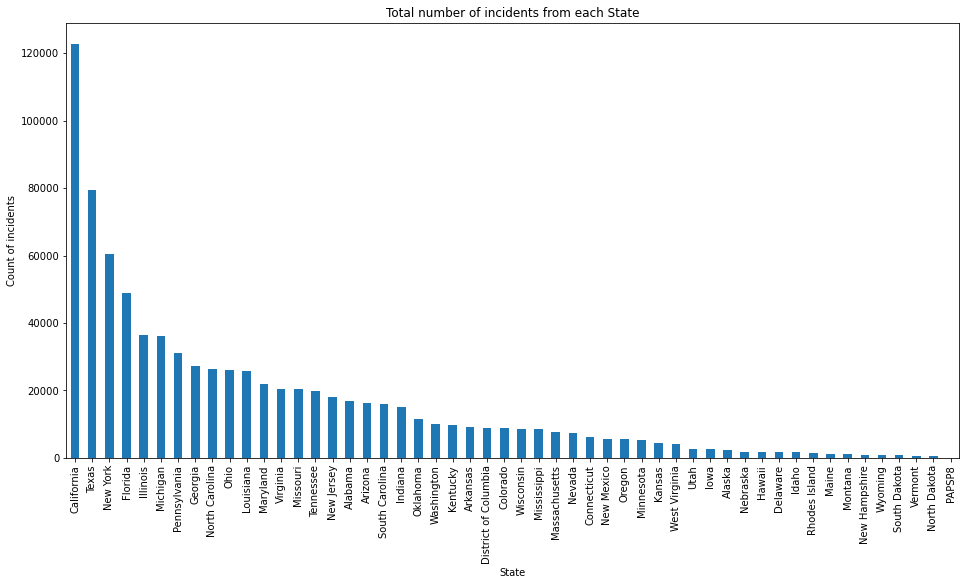

In [147]:
mapdf['state'].value_counts().plot(kind = 'bar',
                                  figsize = (16,8),
                                  xlabel = 'State',
                                  ylabel = 'Count of incidents',
                                  title = 'Total number of incidents from each State');

In [92]:
mapdf['solved'].value_counts()

Yes    583230
No     243989
Name: solved, dtype: int64

#### What about a stacked chart to see unsolved vs solved by state:

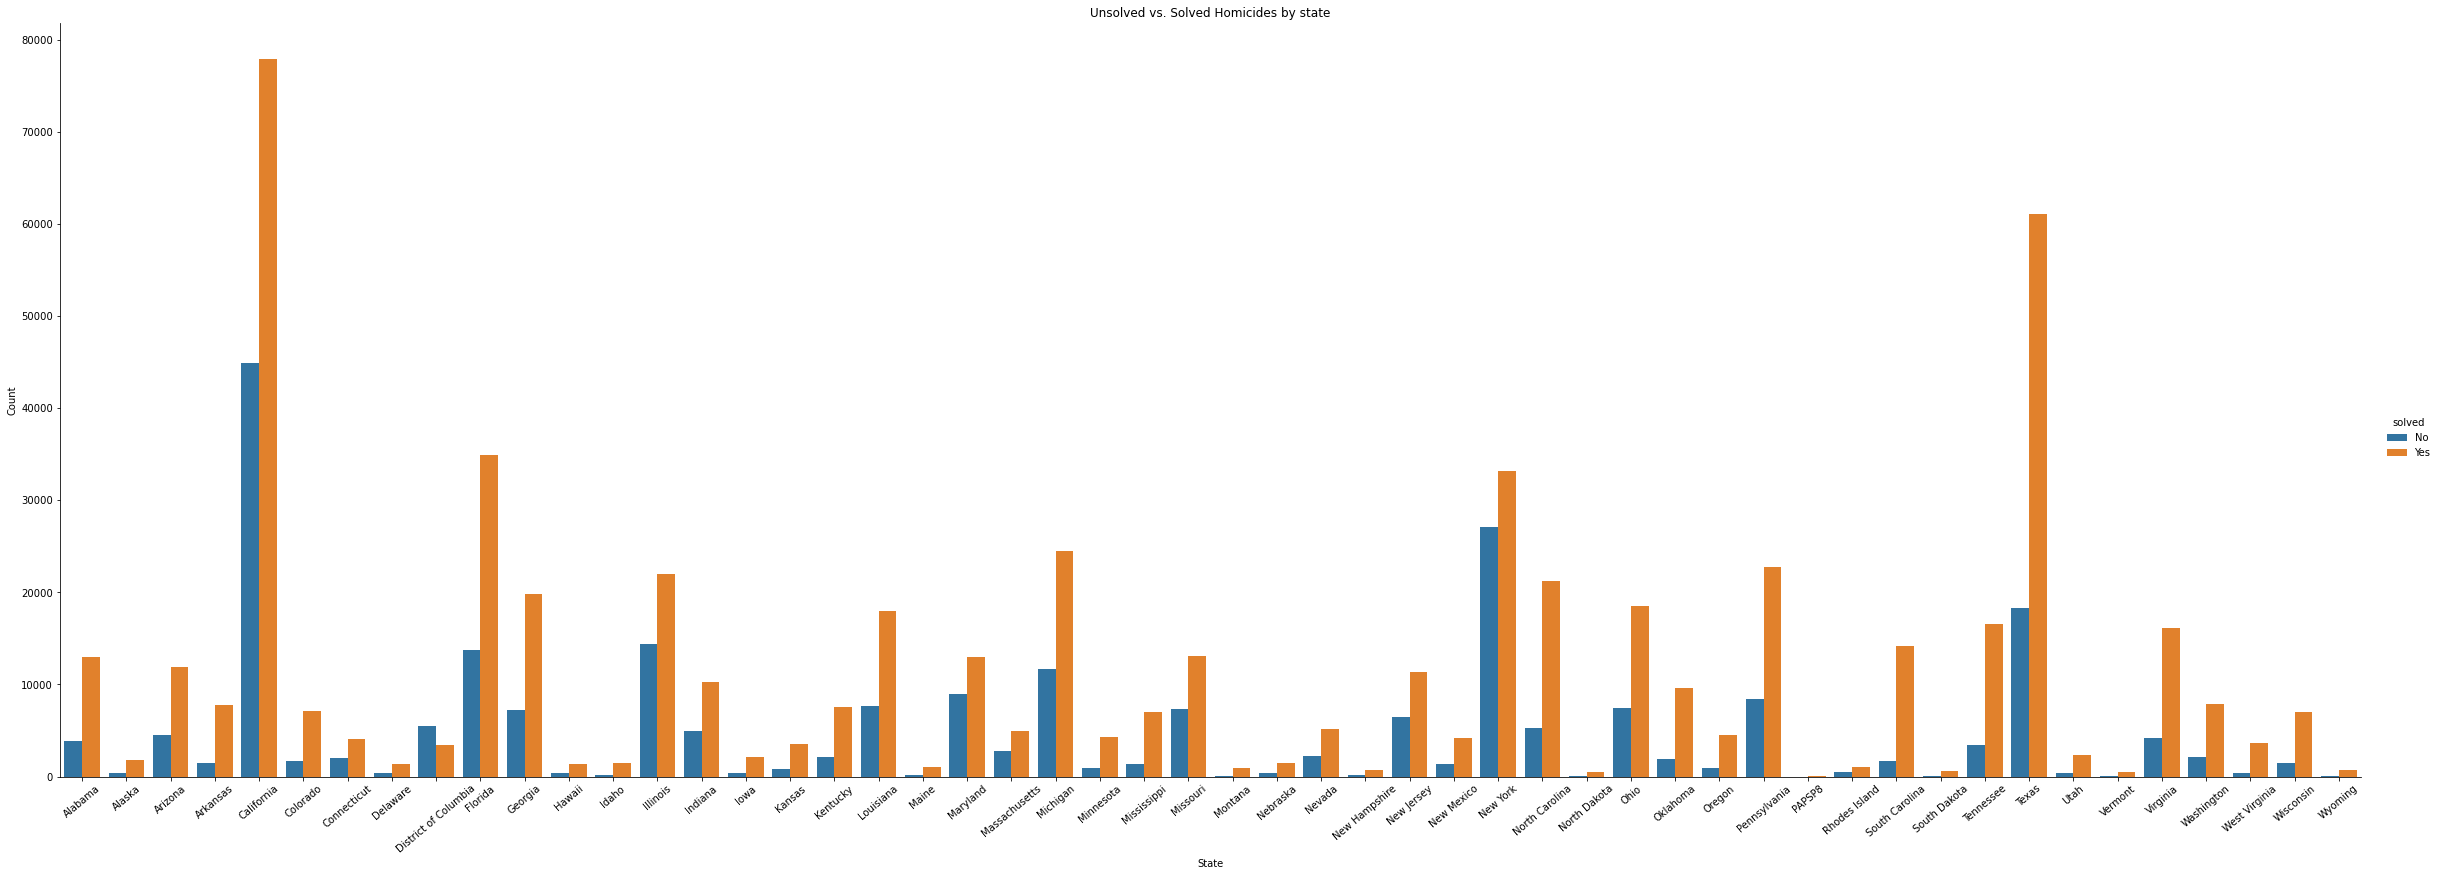

In [108]:
sns.catplot(data = mapdf,
            x = 'state',
            kind = 'count',
            hue = 'solved',
           height = 11,
           aspect = 3)
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Unsolved vs. Solved Homicides by state')
plt.xticks(rotation=40);

In [112]:
mapdf['year'].value_counts().sort_index()

1976    17619
1977    18844
1978    19523
1979    21698
1980    23092
1981    21208
1982    20544
1983    19653
1984    18093
1985    18386
1986    20125
1987    18783
1988    18779
1989    19868
1990    21246
1991    22657
1992    23793
1993    24337
1994    23246
1995    21194
1996    18996
1997    17830
1998    16089
1999    14644
2000    14692
2001    15821
2002    16287
2003    16532
2004    16246
2005    16852
2006    17294
2007    17327
2008    16430
2009    15857
2010    15133
2011    15119
2012    15390
2013    14841
2014    14702
2015    16358
2016    18022
2017    18712
2018    17341
2019    16836
2020    21180
Name: year, dtype: int64

#### Copying a new dataframe to create a time index df:

In [27]:
mapdf_time = mapdf.copy(deep = True)

In [28]:
mapdf_time.set_index('datetime', inplace = True)

In [29]:
mapdf_time.sort_index(ascending = True, inplace = True)

In [30]:
mapdf_time.head()

,id,cntyfips,ori,state,agency,agentype,source,solved,year,month,...,offrace,offethnic,weapon,relationship,circumstance,viccount,offcount,msa,year_str,monthyear
datetime,,,,,,,,,,,,,,,,,,,,,
1976-01-01,197601110NY03030,"New York, NY",NY03030,New York,New York,Municipal police,FBI,No,1976,January,...,Unknown,Unknown or not reported,"Handgun - pistol, revolver, etc",Relationship not determined,Felon killed by police,0,0,"New York-New Jersey-Long Island, NY-NJ",1976,January-1976
1976-01-01,197601001AR05400,"Phillips, AR",AR05400,Arkansas,Phillips County,Sheriff,FBI,Yes,1976,January,...,Black,Unknown or not reported,Shotgun,Stepfather,Other,0,0,Rural Arkansas,1976,January-1976
1976-01-01,197601001AR05401,"Phillips, AR",AR05401,Arkansas,Helena,Municipal police,FBI,Yes,1976,January,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Ex-husband,Other arguments,0,0,Rural Arkansas,1976,January-1976
1976-01-01,197601002AR05400,"Phillips, AR",AR05400,Arkansas,Phillips County,Sheriff,FBI,Yes,1976,January,...,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Ex-husband,Other,0,0,Rural Arkansas,1976,January-1976
1976-01-01,197601002FL04200,"Marion, FL",FL04200,Florida,Marion County,Sheriff,FBI,Yes,1976,January,...,White,Unknown or not reported,Rifle,Relationship not determined,Other arguments,0,0,"Ocala, FL",1976,January-1976


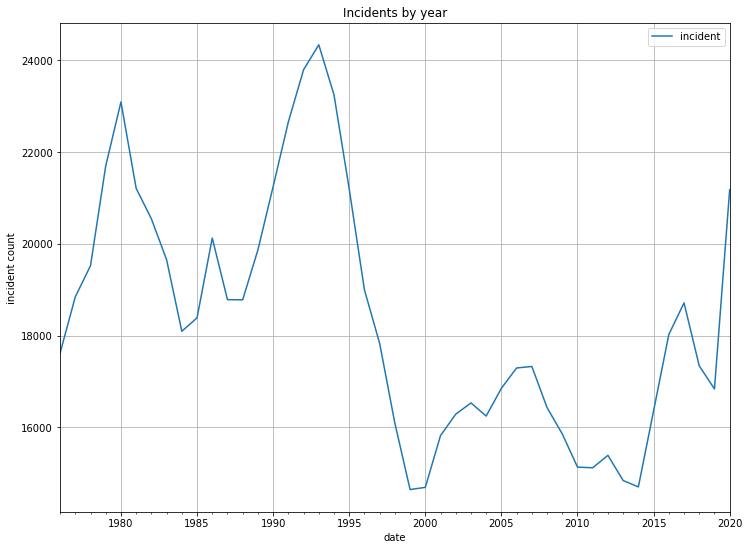

In [123]:
mapdf_time.resample('Y').count().plot(y= ['incident'],
                                     figsize = (12,9),
                                     xlabel = 'date',
                                     ylabel = 'incident count',
                                     title = 'Incidents by year',
                                     grid = True);

In [32]:
mapdf.groupby('agentype')['id'].count().sort_values(ascending = False)

agentype
Municipal police    641556
Sheriff             139930
County police        23638
Primary state LE     19746
Special police        1568
Tribal                 435
Regional police        342
4                        4
Name: id, dtype: int64

In [33]:
mapdf.groupby('year')['id'].count()

year
1976    17619
1977    18844
1978    19523
1979    21698
1980    23092
1981    21208
1982    20544
1983    19653
1984    18093
1985    18386
1986    20125
1987    18783
1988    18779
1989    19868
1990    21246
1991    22657
1992    23793
1993    24337
1994    23246
1995    21194
1996    18996
1997    17830
1998    16089
1999    14644
2000    14692
2001    15821
2002    16287
2003    16532
2004    16246
2005    16852
2006    17294
2007    17327
2008    16430
2009    15857
2010    15133
2011    15119
2012    15390
2013    14841
2014    14702
2015    16358
2016    18022
2017    18712
2018    17341
2019    16836
2020    21180
Name: id, dtype: int64

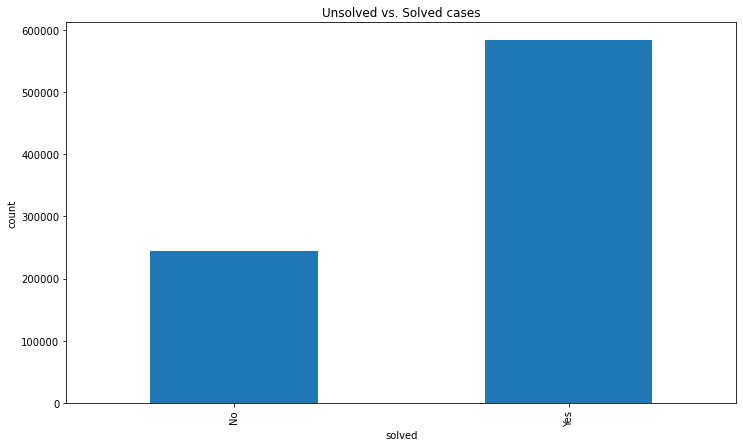

In [ ]:
mapdf.groupby('solved')['id'].count().plot(kind = 'bar',
                                          figsize = (12,7),
                                          ylabel = 'count',
                                          title = 'Unsolved vs. Solved cases');

Realized I should also look at Unsolved cases as well: I guess this leads me to a few questions: 
1. What would happen if we look at just Unsolved cases? 
2. What would happen if we look at the entire dataset? 
3. What would happen if we look at just Solved cases? 
4. Would we see any changes in groupings? 

In [35]:
unsolved_mapdf = mapdf.copy(deep = True)

In [36]:
unsolved_mapdf = unsolved_mapdf[unsolved_mapdf['solved'] == 'No']

In [37]:
unsolved_mapdftime = mapdf_time.copy(deep = True)

In [38]:
unsolved_mapdftime = unsolved_mapdftime[unsolved_mapdftime['solved'] == 'No']

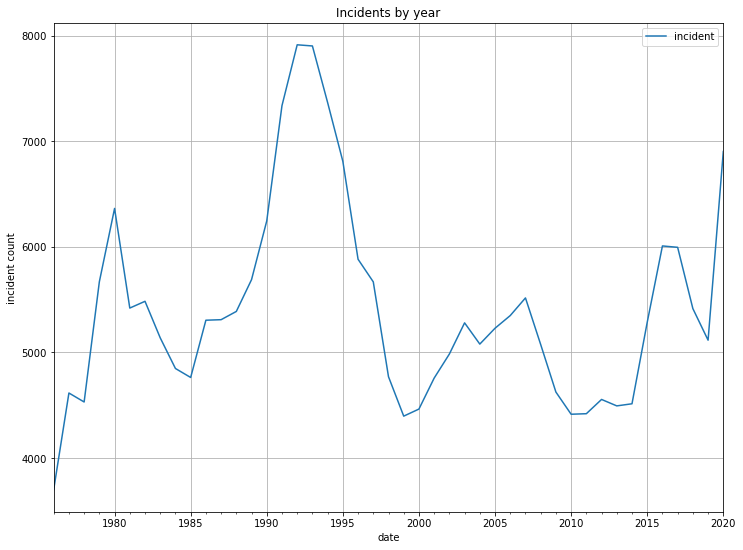

In [39]:
unsolved_mapdftime.resample('Y').count().plot(y= ['incident'],
                                     figsize = (12,9),
                                     xlabel = 'date',
                                     ylabel = 'incident count',
                                     title = 'Incidents by year',
                                     grid = True);

In [40]:
unsolved_mapdftime['vicage'].value_counts()[999]

6449

In [41]:
unsolved_mapdftime['vicage'].value_counts()[0]

1233

In [42]:
unsolved_mapdftime['vicage'].value_counts().sum()

243989

Let's look at the percentage of these 999 + 0 rows from the entire unsolved dataset.

In [43]:
(unsolved_mapdftime['vicage'].value_counts()[999] / unsolved_mapdftime['vicage'].value_counts().sum())*100

2.6431519453745866

In [44]:
(unsolved_mapdftime['vicage'].value_counts()[0] / unsolved_mapdftime['vicage'].value_counts().sum())*100

0.505350651053941

I don't think we should drop them, thought. Might end up losing out on some features that could help ID serial killers.

In [45]:
unsolved_mapdftime['weapon'].value_counts()

Handgun - pistol, revolver, etc         126268
Firearm, type not stated                 34964
Knife or cutting instrument              25042
Other or type unknown                    17919
Blunt object - hammer, club, etc         10957
Personal weapons, includes beating        7998
Shotgun                                   5769
Strangulation - hanging                   4576
Rifle                                     4487
Fire                                      2548
Other gun                                 1324
Asphyxiation - includes death by gas      1196
Narcotics or drugs, sleeping pills         357
Drowning                                   270
Explosives                                 184
Poison - does not include gas               96
Pushed or thrown out window                 34
Name: weapon, dtype: int64

In [46]:
unsolved_mapdftime.columns

Index(['id', 'cntyfips', 'ori', 'state', 'agency', 'agentype', 'source',
       'solved', 'year', 'month', 'incident', 'actiontype', 'homicide',
       'situation', 'vicage', 'vicsex', 'vicrace', 'vicethnic', 'offage',
       'offsex', 'offrace', 'offethnic', 'weapon', 'relationship',
       'circumstance', 'viccount', 'offcount', 'msa', 'year_str', 'monthyear'],
      dtype='object')

Realized the dataset has no identity of what the offender would be because:
1. It's unsolved
2. No one knows who it is
3. What exactly is the predictor variable then? 
4. Is it possible to use a multiple of y to start classifiers?
5. Should I use the solved dataset to start to get the clustering first (train set?)

In [48]:
solved_mapdf = mapdf.copy(deep = True)
solved_mapdf = solved_mapdf[solved_mapdf['solved'] == 'Yes']

In [49]:
solved_mapdf['offrace'].value_counts() # Reset index

White                                  282058
Black                                  280028
Unknown                                  8805
Asian                                    7219
American Indian or Alaskan Native        5001
Native Hawaiian or Pacific Islander       119
Name: offrace, dtype: int64

In [50]:
unsolved_mapdf['offrace'].value_counts()

Unknown                              243358
Black                                   338
White                                   256
Asian                                    28
American Indian or Alaskan Native         9
Name: offrace, dtype: int64

In [51]:
solved_mapdf['offage'].value_counts()[3]

31

In [52]:
# predicting with two -- use two algorithms
# use offage -- use imputation for 999 and 0 -- look at murder age >= 16
# make two separate models: predict Age, predict ethnicity. Drop offage & offeth from both X 

# clustering algorithm on unsolved cases <- are there patterns in the dataset -- geo region / similar murder
# process data - scale
# kmeans / dbscan. kmeans need to specify X serial killers. Optimal number of clusters
# dbscan -- needs distance around each murder & min number to be a serial killer (textbook def?) 

In [53]:
unsolved_mapdf.columns

Index(['id', 'cntyfips', 'ori', 'state', 'agency', 'agentype', 'source',
       'solved', 'year', 'month', 'incident', 'actiontype', 'homicide',
       'situation', 'vicage', 'vicsex', 'vicrace', 'vicethnic', 'offage',
       'offsex', 'offrace', 'offethnic', 'weapon', 'relationship',
       'circumstance', 'viccount', 'offcount', 'msa', 'year_str', 'monthyear',
       'datetime'],
      dtype='object')

In [54]:
solved_mapdf.columns

In [55]:
solved_mapdf['offrace'].value_counts()

White                                  282058
Black                                  280028
Unknown                                  8805
Asian                                    7219
American Indian or Alaskan Native        5001
Native Hawaiian or Pacific Islander       119
Name: offrace, dtype: int64

Here, offender's race is converted into integer cat

In [56]:
race_dict = {'White':0,
            'Black': 1,
            'Unknown': 2,
            'Asian': 3, 
            'American Indian or Alaskan Native': 4,
            'Native Hawaiian or Pacific Islander':5
            }

In [57]:
solved_mapdf['offrace_ohe'] = solved_mapdf['offrace'].map( race_dict)

#### We should impute the data (take the mean?)

In [58]:
X = solved_mapdf.drop(columns = ['offrace', 'id', 'cntyfips', 'ori', 'circumstance', 'msa', 'year_str', 'monthyear', 'actiontype', 'agency', 'agentype', 'source', 'solved', 'datetime', 'offrace_ohe', 'offrace'])
y = solved_mapdf['offrace_ohe']

In [59]:
X['offage'].value_counts()

999    32475
20     26864
19     25162
21     24177
22     23786
       ...  
95        13
96        10
98         9
2          8
97         5
Name: offage, Length: 101, dtype: int64

In [60]:
X['offage'] = X['offage'].replace(999, X['offage'].mean())

In [61]:
X['vicage'] = X['vicage'].replace(999, X['vicage'].mean())

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [64]:
from category_encoders import OneHotEncoder

In [65]:
ohe = OneHotEncoder(cols = ['state', 'weapon', 'vicsex', 'vicrace', 'vicethnic', 'offsex', 'offethnic', 'relationship', 'homicide', 'situation', 'month'], use_cat_names = True)

In [66]:
ohe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


OneHotEncoder(cols=['state', 'weapon', 'vicsex', 'vicrace', 'vicethnic',
                    'offsex', 'offethnic', 'relationship', 'homicide',
                    'situation', 'month'],
              use_cat_names=True)

In [67]:
X_train_cats = ohe.transform(X_train, y_train)

In [68]:
X_test_cats = ohe.transform(X_test, y_test)

In [69]:
model = LinearRegression()

In [70]:
model.fit(X_train_cats, y_train)

LinearRegression()

In [71]:
model.score(X_test_cats, y_test)

0.4506008604226962

In [72]:
model.score(X_train_cats, y_train)

0.45072305124490275

#### Is this bias...? 

In [73]:
model.intercept_

605115776.527435

In [74]:
model.coef_

array([-6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115775e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115775e+08, -6.05115776e+08, -6.05115776e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115775e+08,
       -6.05115776e+08, -6.05115776e+08, -6.05115776e+08, -6.05115776e+08,
        3.74637544e-04, -

In [75]:
X_train_cats.columns

Index(['state_Pennsylvania', 'state_California', 'state_South Carolina',
       'state_North Carolina', 'state_New York', 'state_Georgia',
       'state_Florida', 'state_Arizona', 'state_Ohio', 'state_Indiana',
       ...
       'relationship_Common-law husband', 'relationship_Sister',
       'relationship_Ex-wife', 'relationship_Employee',
       'relationship_Ex-husband', 'relationship_Stepmother',
       'relationship_Stepdaughter', 'relationship_Employer', 'viccount',
       'offcount'],
      dtype='object', length=142)

In [76]:
pd.DataFrame(zip(X_train_cats.columns, model.coef_), columns = ['category', 'coef'])

,category,coef
0,state_Pennsylvania,-6.051158e+08
1,state_California,-6.051158e+08
2,state_South Carolina,-6.051158e+08
3,state_North Carolina,-6.051158e+08
4,state_New York,-6.051158e+08
...,...,...
137,relationship_Stepmother,-6.242227e-02
138,relationship_Stepdaughter,-4.130521e-02
139,relationship_Employer,4.198948e-02
140,viccount,2.994597e-03


In [77]:
y_pred = model.predict(X_test_cats)

In [78]:
mean_squared_error(y_test, y_pred, squared = False)

0.4997587781171392

In [79]:
from sklearn.dummy import DummyRegressor

In [80]:
dum = DummyRegressor()

In [81]:
dum.fit(X_train_cats, y_train)

DummyRegressor()

In [82]:
dum_pred = dum.predict(X_test_cats)

In [83]:
mean_squared_error(y_test, dum_pred, squared = False)

0.6742429958902862

The MSE for LR model is lower than dummy regression. 

#### Of course, Linear Reg is not the right model to run here. Trying LogReg then to K-means